# Autoregressive Image Generation without Vector Quantization

This notebook samples from pre-trained MAR+DiffLoss models, which are class-conditional masked autoregressive models trained on ImageNet to model continuous latent tokens. MAR+DiffLoss achieves state-of-the-art performance on the ImageNet benchmarks. A large portion of this demo is adopted from [DiT](https://github.com/facebookresearch/DiT).

[Paper](https://arxiv.org/abs/2406.11838) | [GitHub](https://github.com/LTH14/mar)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the MAR GitHub repo and setup PyTorch. You only have to run this once.

In [1]:
import os

os.chdir('..')
# MAR imports:

import torch
import numpy as np
from models import create_mar
from models.vae import AutoencoderKL
from torchvision.utils import save_image
from spec_decode import SpecDecodeRunner
from util import download
from PIL import Image
from IPython.display import display

torch.set_grad_enabled(False)
torch.backends.cudnn.benchmark = True

# Download Pre-trained VAE

In [2]:
download.download_pretrained_vae()

# 2. Load and download pre-trained MAR models

In [2]:
draft_model_type = "mar_base"  # @param ["mar_base", "mar_large", "mar_huge"]
target_model_type = "mar_huge"  # @param ["mar_base", "mar_large", "mar_huge"]
num_sampling_steps_diffloss = "100"  # @param {type:"slider", min:1, max:1000, step:1}

draft_model = create_mar(draft_model_type,
                         buffer_size=64,
                         num_sampling_steps=num_sampling_steps_diffloss
                         )
target_model = create_mar(target_model_type,
                          buffer_size=64,
                          num_sampling_steps=num_sampling_steps_diffloss
                          )

state_dict = torch.load(f"./pretrained_models/{draft_model_type}/checkpoint-last.pth", map_location='cpu')["model_ema"]
draft_model.load_state_dict(state_dict)
draft_model.eval()  # important!
draft_model = draft_model.cuda()

state_dict = torch.load(f"./pretrained_models/{target_model_type}/checkpoint-last.pth", map_location='cpu')["model_ema"]
target_model.load_state_dict(state_dict)
target_model.eval()  # important!
target_model = target_model.cuda()

vae = AutoencoderKL(embed_dim=16, ch_mult=(1, 1, 2, 2, 4), ckpt_path="pretrained_models/vae/kl16.ckpt").cuda().eval()
runner = SpecDecodeRunner(draft_model, target_model,ratio=0.05)

Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
Loading pre-trained KL-VAE
Missing keys:
[]
Unexpected keys:
[]
Restored from pretrained_models/vae/kl16.ckpt


# 3. Sample from Pre-trained MAR Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

100%|██████████| 256/256 [01:27<00:00,  2.92it/s]


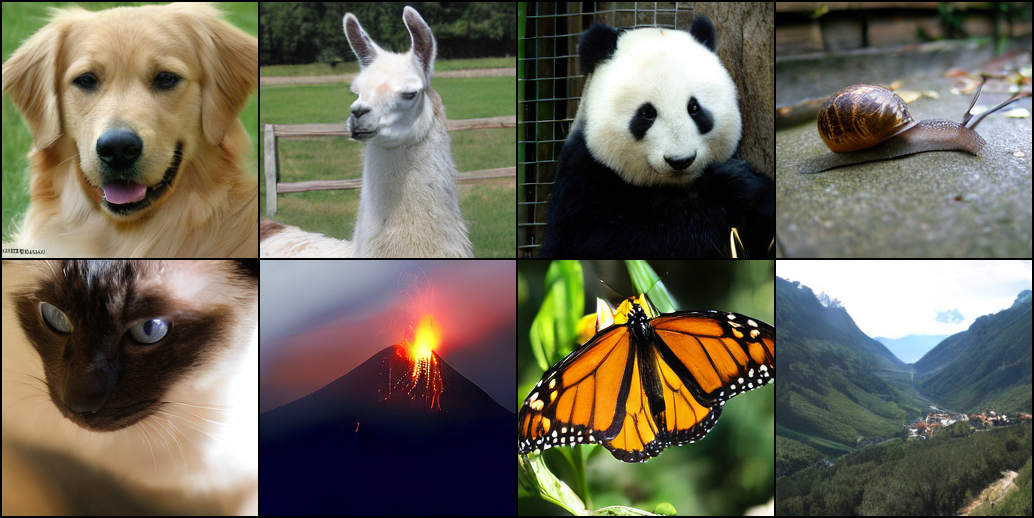

In [3]:
# Set user inputs:
seed = 0  # @param {type:"number"}
torch.manual_seed(seed)
np.random.seed(seed)
num_ar_steps = 256  # @param {type:"slider", min:1, max:256, step:1}
cfg_scale = 4.  # @param {type:"slider", min:1, max:10, step:0.1}
cfg_schedule = "constant"  # @param ["linear", "constant"]
temperature = 1.0  # @param {type:"slider", min:0.9, max:1.1, step:0.01}
class_labels = 207, 355, 388, 113, 284, 980, 323, 979 #@param {type:"raw"}
samples_per_row = 4  # @param {type:"number"}
with torch.inference_mode():
    with torch.cuda.amp.autocast():
        sampled_tokens = runner.run(bsz=len(class_labels),
                                    num_iter=num_ar_steps,
                                    num_draft=4,
                                    cfg_schedule=cfg_schedule,
                                    labels=torch.Tensor(class_labels).long().cuda(),
                                    temperature=temperature,
                                    cfg=cfg_scale,
                                    progress=True)
        sampled_images = vae.decode(sampled_tokens / 0.2325)

# Save and display images:
save_image(sampled_images, "sample.png", nrow=samples_per_row, normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)